# Imports

In [623]:
%matplotlib inline

In [624]:
import torch
import torch
import torch.nn as nn
from   torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np

# Data Preparation

In [625]:
# Firstly we load the data and make it available to the rest of the notebook
with open('../datasets/tinyshakespeare.txt', 'r') as f:
    tiny_shakespeare_corpus = f.read()

In [626]:
data = tiny_shakespeare_corpus[:1000]
data[:250].splitlines()

['First Citizen:',
 'Before we proceed any further, hear me speak.',
 '',
 'All:',
 'Speak, speak.',
 '',
 'First Citizen:',
 'You are all resolved rather to die than to famish?',
 '',
 'All:',
 'Resolved. resolved.',
 '',
 'First Citizen:',
 'First, you know Caius Marcius is chief enemy to the people.']

In [627]:
corpus_chars = sorted(list(set(tiny_shakespeare_corpus)))
vocabulary_size = len(corpus_chars)

print('vocab:', ''.join([char if char != '\n' else '\\n' for char in corpus_chars]))
print('vocab size:', vocabulary_size)

vocab: \n !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
vocab size: 65


# Tokenization

Because we are building a character level model we need to asociate each character from the vocabulary with a number.

First we create our tables of association:

In [628]:
# str to char -> stoi
stoi = { char:i for i, char in enumerate(corpus_chars) }

# int to char -> itos
itos = { i:char for i, char in enumerate(corpus_chars) }

In [629]:
encode = lambda x: [stoi[char] for char in x]
decode = lambda x: ''.join([itos[char] for char in x])

In [630]:
print('encoded:', encode('Hello world!'))
print('decoded:', decode(encode('Hello world!')))

encoded: [20, 43, 50, 50, 53, 1, 61, 53, 56, 50, 42, 2]
decoded: Hello world!


Following this now we are going to encode the entire shakespeare corpus

In [657]:
encoded_shakespeare_corpus = torch.tensor(encode(tiny_shakespeare_corpus), dtype=torch.long)
print(' First 1000 characters from the dataset:\n', encoded_shakespeare_corpus[:1000])

 First 1000 characters from the dataset:
 tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41

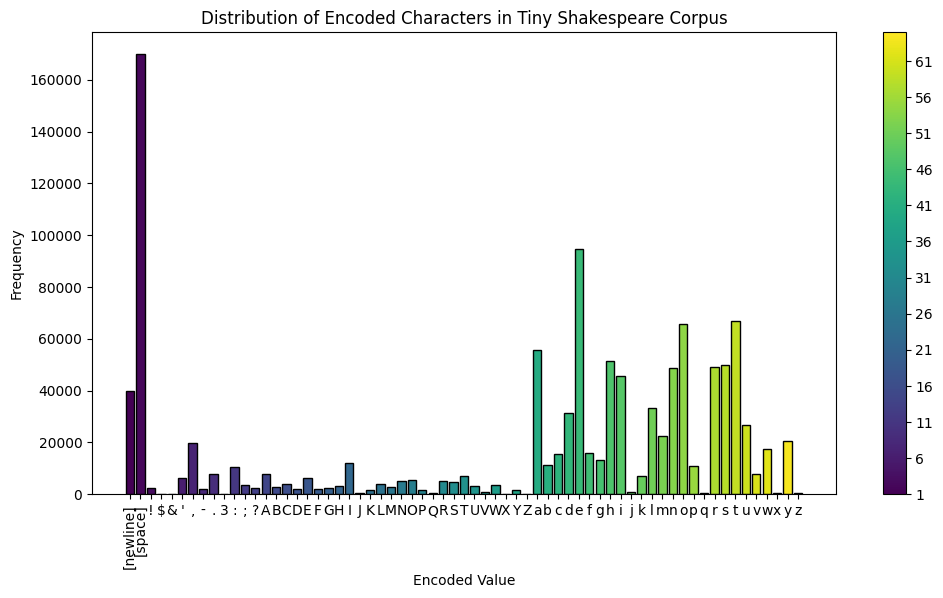

In [673]:
# Prepare labels for special characters
char_labels = []
for char in corpus_chars:
    if char == ' ':
        char_labels.append('[space]')
    elif char == '\n':
        char_labels.append('[newline]')
    else:
        char_labels.append(char)

# Calculate frequencies of each encoded value
frequencies = np.bincount(encoded_shakespeare_corpus.numpy(), minlength=len(corpus_chars))

# Create a colormap
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(vmin=0, vmax=len(corpus_chars)-1)
colors = cmap(norm(range(len(corpus_chars))))

# Plot the distribution of encoded values with character labels and gradient
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(corpus_chars)), frequencies, color=colors, edgecolor='black')
plt.title('Distribution of Encoded Characters in Tiny Shakespeare Corpus')
plt.xlabel('Encoded Value')
plt.ylabel('Frequency')

# Add character labels to x-axis without rotation
plt.xticks(ticks=range(len(corpus_chars)), labels=char_labels)

# Rotate only the labels for space and newline characters
ax = plt.gca()
for label in ax.get_xticklabels():
    if label.get_text() in ['[space]', '[newline]']:
        label.set_rotation(90)

# Add a colorbar to show the gradient
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Create a new axis for the colorbar
cbar = plt.colorbar(sm, ax=ax, ticks=range(0, len(corpus_chars), 5))
cbar.ax.set_yticklabels(range(1, len(corpus_chars)+1, 5))

plt.show()

Now that we have our dataset encoded we are are going to need to separate it and get the training and validation dataset.

In [633]:
training_dataset_size = int(0.9 * len(encoded_shakespeare_corpus))

In [634]:
training_dataset = encoded_shakespeare_corpus[:training_dataset_size]
validation_dataset = encoded_shakespeare_corpus[training_dataset_size:]

# Data Loader

In [635]:
context_length = 8
training_dataset[:context_length+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [636]:
# input sequence
iseq = training_dataset[:context_length]

# target sequence
tseq = training_dataset[1:context_length+1]

for time_step in range(context_length):
    context = iseq[:time_step+1]
    target  = tseq[time_step]
    print(f'when input is {context} the target is {target}')

when input is tensor([18]) the target is 47
when input is tensor([18, 47]) the target is 56
when input is tensor([18, 47, 56]) the target is 57
when input is tensor([18, 47, 56, 57]) the target is 58
when input is tensor([18, 47, 56, 57, 58]) the target is 1
when input is tensor([18, 47, 56, 57, 58,  1]) the target is 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]) the target is 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target is 58


In [637]:
# The number of sequences we are going to process in a batch.
batch_size = 4

# Maximum context length for prdicting the next token.
context_length = 8

In [638]:
torch.manual_seed(1337) # We use this because we want to make sure that the random numbers generated are the same.

In [639]:
def get_batch(dataset):
    batch_indices = torch.randint(len(dataset) - context_length, (batch_size,))

    iseq  = torch.stack([dataset[i:i+context_length] for i in batch_indices])
    tseq  = torch.stack([dataset[i+1:i+context_length+1] for i in batch_indices])

    return iseq, tseq

biseq, btseq = get_batch(training_dataset)

print(biseq.shape)
print(biseq)
print("------------------------------------------")
print(btseq.shape)
print(btseq)

torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
------------------------------------------
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])


In [640]:
for b in range(batch_size):
    for time_step in range(context_length):
        context = biseq[b, :time_step+1]
        target  = btseq[b, time_step]
        print(f"when input is {context.tolist()} the target: {target}")

when input is [24] the target: 43
when input is [24, 43] the target: 58
when input is [24, 43, 58] the target: 5
when input is [24, 43, 58, 5] the target: 57
when input is [24, 43, 58, 5, 57] the target: 1
when input is [24, 43, 58, 5, 57, 1] the target: 46
when input is [24, 43, 58, 5, 57, 1, 46] the target: 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target: 39
when input is [44] the target: 53
when input is [44, 53] the target: 56
when input is [44, 53, 56] the target: 1
when input is [44, 53, 56, 1] the target: 58
when input is [44, 53, 56, 1, 58] the target: 46
when input is [44, 53, 56, 1, 58, 46] the target: 39
when input is [44, 53, 56, 1, 58, 46, 39] the target: 58
when input is [44, 53, 56, 1, 58, 46, 39, 58] the target: 1
when input is [52] the target: 58
when input is [52, 58] the target: 1
when input is [52, 58, 1] the target: 58
when input is [52, 58, 1, 58] the target: 46
when input is [52, 58, 1, 58, 46] the target: 39
when input is [52, 58, 1, 58, 46, 39] the t

In [641]:
torch.manual_seed(1337) # We use this because we want to make sure that the random numbers generated are the same.

In [642]:
class BigramLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.token_embedding_table = nn.Embedding(vocabulary_size, vocabulary_size)

    def forward(self, input_indices, targets=None):
        logits = self.token_embedding_table(input_indices) # (B, T, C)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape

            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, input_indices, max_new_tokens):
        for _ in range(max_new_tokens):
            # Get the predictions
            logits, _ = self(input_indices)
            # Focus only on the last time step
            logits = logits[:, -1, :] # Becomes (B, C)
            # Apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # Sample from the distribution
            input_indices_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # Append sampled index to the running sequence
            input_indices = torch.cat((input_indices, input_indices_next), dim=1) # (B, T+1)

        return input_indices

model = BigramLanguageModel()

logits, loss = model(biseq, btseq)

print(logits.shape)
print(loss)

torch.Size([32, 65])
tensor(4.8786, grad_fn=<NllLossBackward0>)


In [643]:
print(decode(model.generate(input_indices = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=1000)[0].tolist()))


SKIcLT;AcELMoTbvZv C?nq-QE33:CJqkOKH-q;:la!oiywkHjgChzbQ?u!3bLIgwevmyFJGUGp
wnYWmnxKWWev-tDqXErVKLgJt-wBpm&yiltNCjeO3:Cx&vvMYW-txjuAd IRFbTpJ$zkZelxZtTlHNzdXXUiQQY:qFINTOBNLI,&oTigq z.c:Cq,SDXzetn3XVjX-YBcHAUhk&PHdhcOb
nhJ?FJU?pRiOLQeUN!BxjPLiq-GJdUV'hsnla!murI!IM?SPNPq?VgC'R
pD3cLv-bxn-tL!upg
SZ!Uvdg CtxtT?hsiW:XxKIiPlagHIsr'zKSVxza?GlDWObPmRJgrIAcmspmZ&viCKot:u3qYXA:rZgv f:3Q-oiwUzqh'Z!I'zRS3SP rVchSFUIdd q?sPJpUdhMCK$VXXevXJFMl,i
YxA:gWId,EXR,iMC,$?srV$VztRwb?KpgUWFjR$zChOLm;JrDnDph
LBj,KZxJaLPgBAkyzEzSiiQb
jkSVyb$vvyQFuAUAKuzdZAJktRqUiAcPBa;AgJ;.$l3Pu!.IErMfN!PmuQbvx
xMkttN:PmJh'wNC
AUI?wNCphq-.IsCwbjxca;P-KA:r'a;pJ&q-UgOEX.cAO-p,lQ?nEsrlvmUgbEQLQh,j;iPlgZR:CJpxIBju f&!BBEHSPmnq,P -d
pjuWDPLFa!ByCSjJuERtKpph.ZP  CUEsiy'FjF$$-rJUQ?uApxlxlYe
yASBoipGLwfXelgY!a fyFPJX!JDWCoAXRJJFJOlxlvpR?OXYddZAXzkIBtp3d,vAcPlgX'pM fNMLphx&flaAcL!3F.?sBiRwLTqHzot.ttRF$Fv'bL:&x&ayFVqVAHqHxv3QzteqbcUJnERZYGwzLd,rgf&yCnERErI.IVZ WddEJAX CO'Eu!I!Lg:i-$ mIc.
xJjdLEJXVTb?Eqf IgCJcUGNSBZ3dbsEXgCPmr'XxxDXXxE

In [644]:
# Create a PyTorch optimizer for the model
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [645]:
batch_size = 32
print_interval = 1  # Interval at which to print the loss
losses = []

for steps in range(10000):
    # Sample a batch of data
    xb, yb = get_batch(training_dataset)

    # Evaluate the loss
    logits, loss = model(xb, yb)

    # Zero out the gradients
    optimizer.zero_grad(set_to_none=True)

    # Backpropagate
    loss.backward()

    # Update parameters
    optimizer.step()

    # Append the loss to the list
    losses.append(loss.item())

    # Print the loss every 'print_interval' steps
    if steps % print_interval == 0:
        print(f'Step {steps:5}: Loss = {loss.item():.10f}')

Step     0: Loss = 4.7153921127
Step     1: Loss = 4.7812213898
Step     2: Loss = 4.6456861496
Step     3: Loss = 4.7960920334
Step     4: Loss = 4.7833371162
Step     5: Loss = 4.7111535072
Step     6: Loss = 4.7012667656
Step     7: Loss = 4.6120266914
Step     8: Loss = 4.8383798599
Step     9: Loss = 4.7341170311
Step    10: Loss = 4.7075161934
Step    11: Loss = 4.7707905769
Step    12: Loss = 4.8048610687
Step    13: Loss = 4.5596942902
Step    14: Loss = 4.7018570900
Step    15: Loss = 4.7424616814


Step    16: Loss = 4.6726608276
Step    17: Loss = 4.6530833244
Step    18: Loss = 4.7315592766
Step    19: Loss = 4.7638716698
Step    20: Loss = 4.6863532066
Step    21: Loss = 4.6762771606
Step    22: Loss = 4.7206339836
Step    23: Loss = 4.7190852165
Step    24: Loss = 4.6811485291
Step    25: Loss = 4.7270073891
Step    26: Loss = 4.7336225510
Step    27: Loss = 4.6590671539
Step    28: Loss = 4.6893854141
Step    29: Loss = 4.7477931976
Step    30: Loss = 4.6440210342
Step    31: Loss = 4.7079482079
Step    32: Loss = 4.7057256699
Step    33: Loss = 4.6746253967
Step    34: Loss = 4.6771097183
Step    35: Loss = 4.6449561119
Step    36: Loss = 4.6193084717
Step    37: Loss = 4.6717920303
Step    38: Loss = 4.7133631706
Step    39: Loss = 4.7686529160
Step    40: Loss = 4.6488084793
Step    41: Loss = 4.6868057251
Step    42: Loss = 4.6218171120
Step    43: Loss = 4.6507787704
Step    44: Loss = 4.6432566643
Step    45: Loss = 4.7011923790
Step    46: Loss = 4.7439589500
Step    

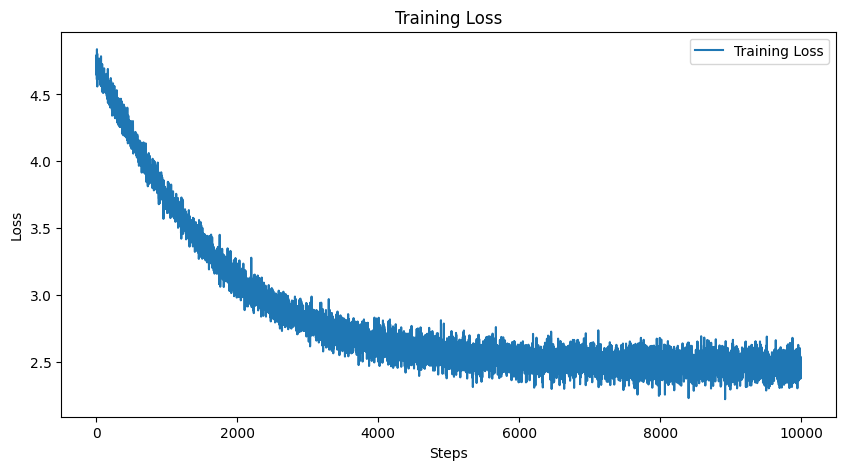

In [646]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(losses)), losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [647]:
print(decode(model.generate(input_indices = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=500)[0].tolist()))


tilllin trk$nutud t ar,
WAnt cithap's Zimponcrdistherdrtes saure ' erpoperrposthelind y ss of hef thep: ct
Ywit harfoul'st, ar izlor t ct.
Fo, sther:
I d tre th,-ben.
Wowstothedl:
NNONANRI, aft,
STo way!
TIV:
WDUKI HANENEThe d ndean-bros g qpl mout fok yolaime do myo asto,
Mok h$ay t nch sle ffonhoured whaneables mye.
For f beng tho; ar!TCald? min, wherure;
Fing tyoucora we d s?

Tord, g Intho heat pr fo.
D:

Anere hurer cr il f aloulatspribr,
AG o otr thall oull
NRartheat.
We

IN eruisfeveg, t 
